In [ ]:
!pip install transformers==4.28.0 datasets evaluate

In [ ]:
import torch
from transformers import DistilBertForQuestionAnswering, DistilBertTokenizerFast, DistilBertConfig
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import default_data_collator
from torch.utils.data import DataLoader
from datasets import load_dataset

In [ ]:
import random

# Set the seed for reproducibility
seed = 2
random.seed(seed)

# Assuming you have already imported the necessary libraries and loaded the dataset
squad_v2_dataset = load_dataset("squad_v2")

# Get the total number of examples in the dataset
num_examples = len(squad_v2_dataset["train"])

# Randomly select 1000 indices without replacement
random_indices = random.sample(range(num_examples), 1000)

# Select the examples corresponding to the random indices
selected_examples = squad_v2_dataset["train"].select(random_indices)

# Now you can use the selected_examples as desired


In [ ]:
xselected_examples['context'][0]

"The pricing of risk refers to the incremental compensation required by investors for taking on additional risk, which may be measured by interest rates or fees. Several scholars have argued that a lack of transparency about banks' risk exposures prevented markets from correctly pricing risk before the crisis, enabled the mortgage market to grow larger than it otherwise would have, and made the financial crisis far more disruptive than it would have been if risk levels had been disclosed in a straightforward, readily understandable format."

In [ ]:
selected_examples['question'][0]

'What is a measurement of pricing of risk?'

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
config = DistilBertConfig.from_pretrained("distilbert-base-uncased")
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased", config=config)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this mode

In [ ]:
def prepare_data(examples):
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=512,  # You can adjust this value as mentioned in the previous answers
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding=True,
    )

    # Find the maximum sequence length based on the tokenized examples
    max_sequence_length = max(len(input_ids) for input_ids in tokenized_examples["input_ids"])
    print("Maximum sequence length:", max_sequence_length)
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_examples.pop("offset_mapping")

    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        sequence_ids = tokenized_examples.sequence_ids(i)

        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]

        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1

            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1

            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)

                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples


In [ ]:
squad_v2_encoded = selected_examples.map(prepare_data, batched=True)


In [ ]:
def custom_data_collator(batch):
    input_ids = torch.tensor([item["input_ids"] for item in batch])
    attention_mask = torch.tensor([item["attention_mask"] for item in batch])
    start_positions = torch.tensor([item["start_positions"] for item in batch])
    end_positions = torch.tensor([item["end_positions"] for item in batch])

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "start_positions": start_positions,
        "end_positions": end_positions,
    }

train_dataloader = DataLoader(squad_v2_encoded, batch_size=8, collate_fn=custom_data_collator)
eval_dataloader = DataLoader(squad_v2_encoded, batch_size=8, collate_fn=custom_data_collator)

In [ ]:
# data_collator = default_data_collator
# train_dataloader = DataLoader(squad_v2_encoded["train"], batch_size=8, collate_fn=data_collator)
# eval_dataloader = DataLoader(squad_v2_encoded["validation"], batch_size=8, collate_fn=data_collator)

In [ ]:
optimizer = AdamW(model.parameters(), lr=3e-4)
num_training_steps = len(train_dataloader) * 3  # Number of epochs
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [ ]:
import torch
from torch.utils.data import DataLoader
import random
from datasets import load_dataset

def answer_question(question, context, model, tokenizer, device):
    inputs = tokenizer(question, context, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move the input tensors to the same device as the model
    outputs = model(**inputs)
    start_position = torch.argmax(outputs.start_logits)
    end_position = torch.argmax(outputs.end_logits)
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][start_position:end_position + 1]))
    return answer



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_values = []
accuracy_values = []
for epoch in range(6):
    model.train()
    print(f"Epoch: {epoch + 1}")
    total_loss = 0.0
    total_correct = 0
    total_examples = 0

    for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        start_positions = outputs.start_logits.argmax(dim=1)
        end_positions = outputs.end_logits.argmax(dim=1)
        correct_start = (start_positions == batch["start_positions"])
        correct_end = (end_positions == batch["end_positions"])
        total_correct += (correct_start & correct_end).sum().item()
        total_examples += len(correct_start)

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        # Print the loss and accuracy at every nth step (e.g., every 10 steps)
        if step % 10 == 0:
            print(f"Step: {step}, Loss: {loss.item()}, Accuracy: {total_correct / total_examples:.2%}")

    # Print the average loss and accuracy for the epoch

    average_loss = total_loss / len(train_dataloader)
    accuracy = total_correct / total_examples
    loss_values.append(average_loss)
    accuracy_values.append(accuracy)
    print(f"Epoch {epoch + 1} - Average Loss: {average_loss}, Accuracy: {accuracy:.2%}")

    # Evaluate the model after each epoch using the answer_question function
    model.eval()
    with torch.no_grad():
        question = "What is the capital of France?"
        context = "France is a country in Europe. Its capital is Paris, which is known for its culture, history, and architecture."
        answer = answer_question(question, context, model, tokenizer, device)
        print(f"Epoch {epoch + 1} - Question: {question}")
        print(f"Epoch {epoch + 1} - Answer: {answer}")

print("Training finished!")


Epoch: 1
Step: 0, Loss: 6.2408905029296875, Accuracy: 0.00%
Step: 10, Loss: 3.885615348815918, Accuracy: 23.86%
Step: 20, Loss: 3.712367534637451, Accuracy: 29.17%
Step: 30, Loss: 3.660287618637085, Accuracy: 28.23%
Step: 40, Loss: 3.924694538116455, Accuracy: 30.18%
Step: 50, Loss: 3.563868999481201, Accuracy: 29.17%
Step: 60, Loss: 3.9839134216308594, Accuracy: 28.48%
Step: 70, Loss: 2.9807662963867188, Accuracy: 27.99%
Step: 80, Loss: 3.172863721847534, Accuracy: 28.86%
Step: 90, Loss: 2.571927547454834, Accuracy: 29.81%
Step: 100, Loss: 4.367620468139648, Accuracy: 30.20%
Step: 110, Loss: 4.429742336273193, Accuracy: 31.31%
Step: 120, Loss: 3.371699571609497, Accuracy: 31.61%
Epoch 1 - Average Loss: 3.3695121240615844, Accuracy: 31.60%
Epoch 1 - Question: What is the capital of France?
Epoch 1 - Answer: [CLS]
Epoch: 2
Step: 0, Loss: 2.6129891872406006, Accuracy: 37.50%
Step: 10, Loss: 3.1769659519195557, Accuracy: 32.95%
Step: 20, Loss: 1.7943074703216553, Accuracy: 33.93%
Step: 30

In [ ]:
loss_values

[3.3695121240615844,
 2.196681787490845,
 0.751379121363163,
 0.32926976430416105,
 0.32107060927152636,
 0.31808825325965884]

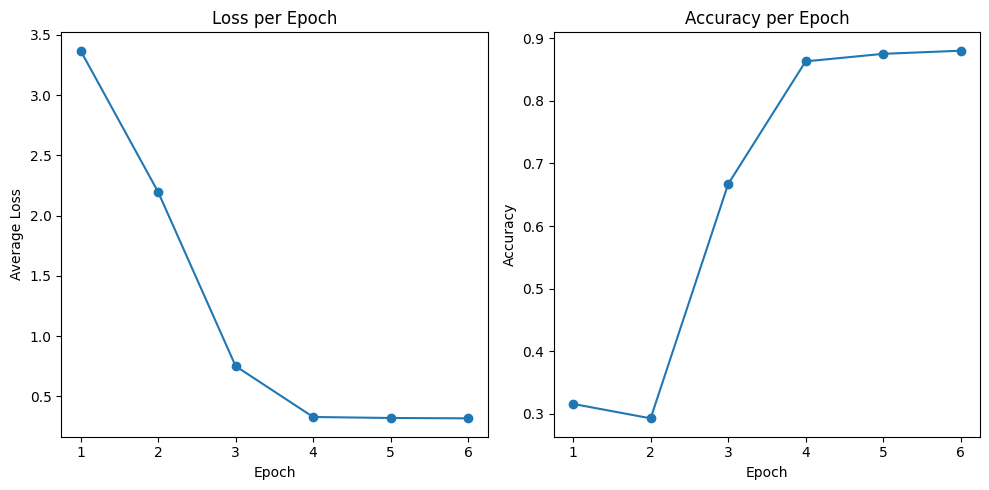

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 7), loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Loss per Epoch')

plt.subplot(1, 2, 2)
plt.plot(range(1, 7), accuracy_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')

plt.tight_layout()
plt.show()

In [ ]:
/content/model_weights.pth

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')


In [ ]:
# First, create the model instance and load the saved weights
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased", config=config)
model.load_state_dict(torch.load('model_weights.pth'))

# Then, move the model to the desired device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Now, you can use the loaded model for inference or further training if needed


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this mode

DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
      

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForQuestionAnswering

# Load the tokenizer and model architecture
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
config = DistilBertConfig.from_pretrained("distilbert-base-uncased")
model = DistilBertForQuestionAnswering(config)

# Load the saved weights into the model
model.load_state_dict(torch.load('model_weights.pth'))

# Move the model to the desired device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
      

In [ ]:
import torch

def answer_question(question, context, model, tokenizer, device):
    inputs = tokenizer(question, context, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move the input tensors to the same device as the model
    outputs = model(**inputs)
    start_position = torch.argmax(outputs.start_logits)
    end_position = torch.argmax(outputs.end_logits)
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][start_position:end_position + 1]))
    return answer


In [ ]:
question = "What is the capital of France?"
context = "France is a country in Europe. Its capital is Paris, which is known for its culture, history, and architecture."

answer = answer_question(question, context, model, tokenizer, device)

print("Question:", question)
print("Answer:", answer)


Question: What is the capital of France?
Answer: paris


In [ ]:
question = "What is the capital of Japan?"
context = "Japan is an island nation in East Asia. The capital is Tokyo, which is a bustling metropolis known for its modern technology, rich culture, and historical landmarks."

answer = answer_question(question, context, model, tokenizer, device)

print("Question:", question)
print("Answer:", answer)


Question: What is the capital of Japan?
Answer: tokyo


In [ ]:
question = "Who is the 44th President of the United States?"
context = "The 44th President of the United States is Barack Obama. He served as the President from January 20, 2009, to January 20, 2017."

answer = answer_question(question, context, model, tokenizer, device)
print("Question:", question)
print("Answer:", answer)


Question: Who is the 44th President of the United States?
Answer: barack obama
